In [274]:
import pandas as pd
import numpy as np
import pymysql
import pymysql.cursors
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline
import statsmodels.api as sm
#from StochasticDiffusionSearchFeatureSelectionmaster import SDSFS as s
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [ ]:
# https://medium.com/@sagar.rawale3/feature-selection-methods-in-machine-learning-eaeef12019cc
# Really a good article on Feature selection

In [275]:
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore') # suppress warnings
import random
random.seed(1234)

In [276]:
pd.describe_option('display')
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 500)

display.chop_threshold : float or None
    if set to a float value, all float values smaller then the given threshold
    will be displayed as exactly 0 by repr and friends.
    [default: None] [currently: None]

display.colheader_justify : 'left'/'right'
    Controls the justification of column headers. used by DataFrameFormatter.
    [default: right] [currently: right]

display.column_space No description available.
    [default: 12] [currently: 12]

display.date_dayfirst : boolean
    When True, prints and parses dates with the day first, eg 20/01/2005
    [default: False] [currently: False]

display.date_yearfirst : boolean
    When True, prints and parses dates with the year first, eg 2005/01/20
    [default: False] [currently: False]

display.encoding : str/unicode
    Defaults to the detected encoding of the console.
    Specifies the encoding to be used for strings returned by to_string,
    these are generally strings meant to be displayed on the console.
    [default: UTF-8] 

In [277]:
full = pd.read_csv('full.csv',engine='python') #~50sec

In [278]:
full = full.drop(full.columns[full.columns.str.contains('unnamed',case = False)],axis = 1)

In [279]:
full['WEIGHT'] = full['WEIGHT'].replace(1.000000e+16,np.nan)
full['WEIGHT'] = full['WEIGHT'].replace(' ',np.nan)
full['WEIGHT'] = full['WEIGHT'].fillna(9)
full['WEIGHT'] = full['WEIGHT'].astype(int)

In [280]:
full_c = pd.DataFrame(data = full, columns =['ACC_TYPE','BUS_USE','CDL_STAT','DAY','DRIMPAIR','DR_DRINK','DR_HGT','DR_SF1','DR_SF2','DR_SF3','DR_SF4',
          'EMER_USE','HARM_EV','HOUR','HAZ_PLAC','IMPACT1','LAST_YR','L_COMPL','L_RESTRI','L_STATUS','L_TYPE','MAKE','MAN_COLL',
          'MDRDSTRD','MDRMANAV','MFACTOR','MINUTE','MOD_YEAR','MONTH','MVIOLATN','MVISOBSC','OWNER','P_CRASH2','ROLLOVER','SPEC_USE',
          'SPEEDREL','STATE','TOW_VEH','VALIGN','VEH_SC1','VEH_SC2','VINTYPE','VPAVETYP','VPROFILE','VSURCOND','VTCONT_F','VTRAFCON'])

In [281]:
full_c = full_c.apply(lambda x: x.astype('category')) #categories
#print(full_c.dtypes)

In [282]:
full_o = pd.DataFrame(data = full, columns =['DR_WGT','GVWR','WEIGHT'])#.apply(lambda x: x.astype('category'), ordered = True))

In [283]:
full_o = full_o.apply(lambda x: x.astype('category',ordered=True)) #Ordinal
#print(full_o.dtypes)

In [284]:
full_p = pd.DataFrame(data = full, columns =['DEATHS','NUMOCCS','PREV_ACC','PREV_DWI','PREV_SPD','PREV_SUS','VE_FORMS','VNUM_LAN',
                                             'VTRAFWAY','FIRE_EXP','HAZ_INV','HIT_RUN','TRAV_SP'])
# count variables were left as is.

In [285]:
full = pd.concat([full_o, full_c, full_p], axis = 1)

In [286]:
vin_type = full.copy()
vin_type.head()

clean_up = {"VINTYPE" : {'P' : 0, "T" : 1, "M" : 2,"U" : 3,"C" : 4}}

vin_type.replace(clean_up, inplace = True)
print(vin_type.head())

full['VINTYPE'] = vin_type['VINTYPE']
#np.isnan(full['VINTYPE'])

  DR_WGT GVWR WEIGHT ACC_TYPE BUS_USE CDL_STAT DAY DRIMPAIR DR_DRINK DR_HGT  \
0    137    0      9        6       0        0  11        0        0     65   
1    300    0      9       69       0        0  14        0        0     80   
2    140    0      9       68       0        0  14        0        0     61   
3    124    0      9       98       0        0  14        0        0     66   
4    140    0      9       52       0        0  21        0        0     73   

  DR_SF1 DR_SF2 DR_SF3 DR_SF4 EMER_USE HARM_EV HOUR HAZ_PLAC IMPACT1 LAST_YR  \
0      0      0      0      0        0      30    6        0      12       0   
1      0      0      0      0        0      12   15        0      13    2009   
2     38      0      0      0        0      12   15        0      12    2008   
3      0      0      0      0        0      12   15        0      12       0   
4     51      0      0      0        0      12    1        0      12       0   

  L_COMPL L_RESTRI L_STATUS L_TYPE MAKE MAN_

In [287]:
full = full.dropna()
full.shape

(296847, 63)

In [288]:
cols = full.columns.tolist()
cols
cols = ['DR_WGT','GVWR','WEIGHT', 'ACC_TYPE', 'BUS_USE', 'CDL_STAT', 'DAY', 'DRIMPAIR', 'DR_DRINK', 'DR_HGT', 'DR_SF1', 'DR_SF2', 'DR_SF3',
        'DR_SF4','EMER_USE','HARM_EV','HOUR','HAZ_PLAC','IMPACT1','LAST_YR', 'L_COMPL', 'L_RESTRI', 'L_STATUS', 'L_TYPE', 'MAKE',
        'MAN_COLL','MDRDSTRD', 'MDRMANAV', 'MFACTOR', 'MINUTE', 'MOD_YEAR', 'MONTH', 'MVIOLATN', 'MVISOBSC', 'OWNER', 'P_CRASH2',
        'ROLLOVER','SPEC_USE', 'SPEEDREL', 'STATE', 'TOW_VEH', 'VALIGN', 'VEH_SC1', 'VEH_SC2', 'VINTYPE', 'VPAVETYP', 'VPROFILE',
        'VSURCOND','VTCONT_F', 'VTRAFCON', 'PREV_DWI', 'NUMOCCS', 'PREV_ACC', 'PREV_SPD', 'PREV_SUS', 'VE_FORMS', 'VNUM_LAN',
        'VTRAFWAY', 'FIRE_EXP', 'HAZ_INV', 'HIT_RUN', 'TRAV_SP', 'DEATHS']
full = full[cols]

In [289]:
# CREATE A NEW BINARY VARIABLE : 0 -if no deaths. 1- if # of deaths >= 1
full['DEATHS_BIN'] = full['DEATHS'].apply(lambda x: 1 if x>=1 else 0)

In [290]:
full = full.drop(['DEATHS'], axis=1)
print("Size of the dataset:",full.shape)

Size of the dataset: (296847, 63)


In [291]:
full.isnull().any().isnull().any()

False

In [292]:
full.head()

,DR_WGT,GVWR,WEIGHT,ACC_TYPE,BUS_USE,CDL_STAT,DAY,DRIMPAIR,DR_DRINK,DR_HGT,DR_SF1,DR_SF2,DR_SF3,DR_SF4,EMER_USE,HARM_EV,HOUR,HAZ_PLAC,IMPACT1,LAST_YR,L_COMPL,L_RESTRI,L_STATUS,L_TYPE,MAKE,MAN_COLL,MDRDSTRD,MDRMANAV,MFACTOR,MINUTE,MOD_YEAR,MONTH,MVIOLATN,MVISOBSC,OWNER,P_CRASH2,ROLLOVER,SPEC_USE,SPEEDREL,STATE,TOW_VEH,VALIGN,VEH_SC1,VEH_SC2,VINTYPE,VPAVETYP,VPROFILE,VSURCOND,VTCONT_F,VTRAFCON,PREV_DWI,NUMOCCS,PREV_ACC,PREV_SPD,PREV_SUS,VE_FORMS,VNUM_LAN,VTRAFWAY,FIRE_EXP,HAZ_INV,HIT_RUN,TRAV_SP,DEATHS_BIN
0,137,0,9,6,0,0,11,0,0,65,0,0,0,0,0,30,6,0,12,0,3,0,6,1,9,0,0,0,0,0,1998,1,0,13,1,12,0,0,0,1,0,1,0,0,0.0,2,1,1,0,0,0,1,0,0,0,1,2,1,0,1,0,999,1
1,300,0,9,69,0,0,14,0,0,80,0,0,0,0,0,12,15,0,13,2009,2,1,6,1,53,11,0,4,0,10,2005,1,0,0,1,64,0,0,1,1,0,1,0,0,2.0,2,1,1,0,0,0,1,1,0,0,3,2,2,0,1,0,999,1
2,140,0,9,68,0,0,14,0,0,61,38,0,0,0,0,12,15,0,12,2008,3,0,6,1,49,11,0,0,0,10,2008,1,0,0,1,15,0,0,0,1,0,1,0,0,0.0,2,1,1,0,0,0,1,1,0,0,3,2,2,0,1,0,10,0
3,124,0,9,98,0,0,14,0,0,66,0,0,0,0,0,12,15,0,12,0,3,1,6,1,35,11,0,0,0,10,2006,1,0,0,1,98,0,0,0,1,0,1,0,0,0.0,2,1,1,3,20,0,1,0,0,0,3,2,1,0,1,0,0,0
4,140,0,9,52,0,0,21,0,0,73,51,0,0,0,0,12,1,0,12,0,3,1,6,1,24,2,0,0,0,16,1994,1,0,0,0,10,1,0,0,1,0,1,0,0,0.0,2,3,2,0,0,0,1,0,0,0,2,2,1,0,1,0,999,1


In [293]:
X=np.array(full[list(full.columns[:-1])])
X.dtype

dtype('O')

In [294]:
y=full['DEATHS_BIN']
y.dtype

dtype('int64')

# SDSFS : USING LOGISTIC REGRESSION + DECISION TREE

In [297]:
#SDSFS(Xtrain,ytrain,estimators,150,50,5,12)
agents1,agentFIndex1,agentStatus1,agentScores1=SDSFS(X,y,estimators,10,20,5,25)

In [298]:
max(agentScores1)
 #It takes a feature matrix X_test and the expected target values y_test. Predictions for X_test are compared with y_test and either accuracy (for classifiers) or R² score (for regression estimators is returned.

0.8104147577211233

In [299]:
val1 = np.argmax(np.array(agentScores1))
val1

11

In [300]:
agents1[val1].shape #40 variables

(296847, 23)

In [301]:
agent_list=[]
for i in range(len(agentFIndex1[val1])):
    if agentFIndex1[val1][i] == 1:
        agent_list.append(cols[i])
print(agent_list)

['GVWR', 'WEIGHT', 'BUS_USE', 'DRIMPAIR', 'DR_SF3', 'DR_SF4', 'EMER_USE', 'HOUR', 'IMPACT1', 'L_COMPL', 'MDRMANAV', 'MONTH', 'MVIOLATN', 'P_CRASH2', 'STATE', 'VEH_SC1', 'VINTYPE', 'PREV_DWI', 'NUMOCCS', 'PREV_ACC', 'VNUM_LAN', 'FIRE_EXP', 'TRAV_SP']


In [302]:
X_train,X_test,y_train,y_test=train_test_split(agents1[val1],y, random_state=0)

In [303]:
logReg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [304]:
logReg_score2=logReg.score(X_test,y_test) 
print(logReg_score2)

0.8016897536786504


In [305]:
decClf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [306]:
decClf_score2=decClf.score(X_test,y_test) #accuracy increased by 10 percent
print(decClf_score2)

0.8191397617635962


In [307]:
# Results of feature selection for 10iterations, 20 agents, min 5 and max 25 features - 23 variables 
# Logistic Regression accuracy : 0.8016
# Decision Trees : 0.8191
# ['GVWR', 'WEIGHT', 'BUS_USE', 'DRIMPAIR', 'DR_SF3', 'DR_SF4', 'EMER_USE', 'HOUR', 'IMPACT1', 'L_COMPL', 'MDRMANAV', 'MONTH', 'MVIOLATN', 'P_CRASH2', 'STATE', 'VEH_SC1', 'VINTYPE', 'PREV_DWI', 'NUMOCCS', 'PREV_ACC', 'VNUM_LAN', 'FIRE_EXP', 'TRAV_SP']

In [ ]:
# Results of feature selection for 10iterations, 20 agents, min 5 and max 50 features - 40 variables 
# Logistic Regression accuracy : 0.83

# Decision Trees : 0.8323
# ['DR_WGT', 'GVWR', 'WEIGHT', 'ACC_TYPE', 'BUS_USE', 'DAY', 'DRIMPAIR', 'DR_DRINK', 'DR_HGT', 'DR_SF3', 'HARM_EV', 'HOUR', 'L_COMPL', 'L_RESTRI', 'MAKE', 'MINUTE', 'MOD_YEAR', 'MONTH', 'MVIOLATN', 'MVISOBSC', 'OWNER', 'P_CRASH2', 'ROLLOVER', 'SPEC_USE', 'VALIGN', 'VEH_SC2', 'VINTYPE', 'VPAVETYP', 'VPROFILE', 'VSURCOND', 'VTRAFCON', 'PREV_DWI', 'NUMOCCS', 'PREV_SPD', 'PREV_SUS', 'VE_FORMS', 'VNUM_LAN', 'VTRAFWAY', 'HAZ_INV', 'TRAV_SP']

# SDSFS : USING LOGISTIC REGRESSION

In [353]:
agents,agentFIndex,agentStatus,agentScores=SDSFS(X,y,estimators,10,20,5,25)

In [354]:
max(agentScores) #LOGISTIC REGRESSION
#It takes a feature matrix X_test and the expected target values y_test. Predictions for X_test are compared with y_test and either accuracy (for classifiers) or R² score (for regression estimators is returned.

0.7952756966528324

In [355]:
val = np.argmax(np.array(agentScores))
val
agents[val].shape

(296847, 23)

In [356]:
val

18

In [357]:
agent_list=[]
for i in range(len(agentFIndex[val])):
    #print(i)
    if agentFIndex[val][i] == 1:
        agent_list.append(cols[i])
print(agent_list)

['WEIGHT', 'CDL_STAT', 'DR_DRINK', 'LAST_YR', 'MDRDSTRD', 'MOD_YEAR', 'P_CRASH2', 'ROLLOVER', 'STATE', 'TOW_VEH', 'VEH_SC2', 'VINTYPE', 'VPAVETYP', 'VSURCOND', 'VTCONT_F', 'PREV_DWI', 'NUMOCCS', 'PREV_SPD', 'VNUM_LAN', 'VTRAFWAY', 'FIRE_EXP', 'HAZ_INV', 'TRAV_SP']


In [ ]:
['WEIGHT', 'DRIMPAIR', 'DR_SF3', 'HAZ_PLAC', 'LAST_YR', 'L_STATUS', 'MAKE', 'MDRDSTRD', 'MINUTE', 'MOD_YEAR', 'MONTH', 
 'P_CRASH2', 'SPEEDREL', 'TOW_VEH', 'VEH_SC1', 'VINTYPE', 'VTCONT_F', 'NUMOCCS', 'VE_FORMS', 'FIRE_EXP']

In [358]:
var_list = ['WEIGHT', 'CDL_STAT', 'DR_DRINK', 'LAST_YR', 'MDRDSTRD', 'MOD_YEAR', 'P_CRASH2', 'ROLLOVER', 'STATE', 'TOW_VEH', 'VEH_SC2', 'VINTYPE', 'VPAVETYP', 'VSURCOND', 'VTCONT_F', 'PREV_DWI', 'NUMOCCS', 'PREV_SPD', 'VNUM_LAN', 'VTRAFWAY', 'FIRE_EXP', 'HAZ_INV', 'TRAV_SP']
new_df = full.loc[:,var_list]

In [359]:
new_df.head()

,WEIGHT,CDL_STAT,DR_DRINK,LAST_YR,MDRDSTRD,MOD_YEAR,P_CRASH2,ROLLOVER,STATE,TOW_VEH,VEH_SC2,VINTYPE,VPAVETYP,VSURCOND,VTCONT_F,PREV_DWI,NUMOCCS,PREV_SPD,VNUM_LAN,VTRAFWAY,FIRE_EXP,HAZ_INV,TRAV_SP
0,9,0,0,0,0,1998,12,0,1,0,0,0.0,2,1,0,0,1,0,2,1,0,1,999
1,9,0,0,2009,0,2005,64,0,1,0,0,2.0,2,1,0,0,1,0,2,2,0,1,999
2,9,0,0,2008,0,2008,15,0,1,0,0,0.0,2,1,0,0,1,0,2,2,0,1,10
3,9,0,0,0,0,2006,98,0,1,0,0,0.0,2,1,3,0,1,0,2,1,0,1,0
4,9,0,0,0,0,1994,10,1,1,0,0,0.0,2,2,0,0,1,0,2,1,0,1,999


In [360]:
new_df.shape

(296847, 23)

In [365]:
new_df['NUMOCCS'] = new_df['NUMOCCS'].astype('category')

In [369]:
new_df['VINTYPE'] = new_df['VINTYPE'].astype('int')

In [376]:
new_df['VINTYPE'] = new_df['VINTYPE'].astype('category')

In [370]:
new_df['VNUM_LAN'] = new_df['VNUM_LAN'].astype('category')

In [372]:
new_df['PREV_DWI'] = new_df['PREV_DWI'].astype('category')

In [373]:
new_df['PREV_SPD'] = new_df['PREV_SPD'].astype('category')

In [382]:
new_df['VTRAFWAY'] = new_df['VTRAFWAY'].astype('category')

In [383]:
new_df = pd.get_dummies(new_df)

In [384]:
new_df.head()

,FIRE_EXP,HAZ_INV,TRAV_SP,WEIGHT_1,WEIGHT_2,WEIGHT_3,WEIGHT_4,WEIGHT_5,WEIGHT_6,WEIGHT_7,WEIGHT_8,WEIGHT_9,CDL_STAT_0,CDL_STAT_1,CDL_STAT_2,CDL_STAT_3,CDL_STAT_4,CDL_STAT_5,CDL_STAT_6,CDL_STAT_7,CDL_STAT_8,CDL_STAT_98,CDL_STAT_99,DR_DRINK_0,DR_DRINK_1,LAST_YR_0,LAST_YR_2007,LAST_YR_2008,LAST_YR_2009,LAST_YR_2010,LAST_YR_2011,LAST_YR_2012,LAST_YR_2013,LAST_YR_2014,LAST_YR_2015,LAST_YR_2016,LAST_YR_2017,LAST_YR_9999,MDRDSTRD_0,MDRDSTRD_1,MDRDSTRD_3,MDRDSTRD_4,MDRDSTRD_5,MDRDSTRD_6,MDRDSTRD_7,MDRDSTRD_9,MDRDSTRD_10,MDRDSTRD_12,MDRDSTRD_13,MDRDSTRD_14,MDRDSTRD_15,MDRDSTRD_17,MDRDSTRD_18,MDRDSTRD_19,MDRDSTRD_92,MDRDSTRD_93,MDRDSTRD_96,MDRDSTRD_97,MDRDSTRD_98,MDRDSTRD_99,MOD_YEAR_1914,MOD_YEAR_1915,MOD_YEAR_1923,MOD_YEAR_1924,MOD_YEAR_1926,MOD_YEAR_1927,MOD_YEAR_1928,MOD_YEAR_1929,MOD_YEAR_1930,MOD_YEAR_1931,MOD_YEAR_1932,MOD_YEAR_1933,MOD_YEAR_1934,MOD_YEAR_1936,MOD_YEAR_1937,...,NUMOCCS_17,NUMOCCS_18,NUMOCCS_19,NUMOCCS_20,NUMOCCS_21,NUMOCCS_22,NUMOCCS_23,NUMOCCS_24,NUMOCCS_25,NUMOCCS_26,NUMOCCS_27,NUMOCCS_28,NUMOCCS_29,NUMOCCS_30,NUMOCCS_31,NUMOCCS_32,NUMOCCS_33,NUMOCCS_34,NUMOCCS_35,NUMOCCS_36,NUMOCCS_37,NUMOCCS_38,NUMOCCS_39,NUMOCCS_40,NUMOCCS_41,NUMOCCS_42,NUMOCCS_43,NUMOCCS_44,NUMOCCS_45,NUMOCCS_46,NUMOCCS_47,NUMOCCS_49,NUMOCCS_50,NUMOCCS_51,NUMOCCS_52,NUMOCCS_53,NUMOCCS_57,NUMOCCS_58,NUMOCCS_60,PREV_SPD_0,PREV_SPD_1,PREV_SPD_2,PREV_SPD_3,PREV_SPD_4,PREV_SPD_5,PREV_SPD_6,PREV_SPD_7,PREV_SPD_8,PREV_SPD_9,PREV_SPD_10,PREV_SPD_11,PREV_SPD_13,PREV_SPD_14,VNUM_LAN_0,VNUM_LAN_1,VNUM_LAN_2,VNUM_LAN_3,VNUM_LAN_4,VNUM_LAN_5,VNUM_LAN_6,VNUM_LAN_7,VINTYPE_0,VINTYPE_1,VINTYPE_2,VINTYPE_3,VINTYPE_4,VTRAFWAY_0,VTRAFWAY_1,VTRAFWAY_2,VTRAFWAY_3,VTRAFWAY_4,VTRAFWAY_5,VTRAFWAY_6,VTRAFWAY_8,VTRAFWAY_9
0,0,1,999,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,1,999,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,0,1,10,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,999,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [385]:
new_df.insert(409,column='DEATHS_BIN',value=full['DEATHS_BIN'])

In [386]:
X=np.array(new_df[list(new_df.columns[:-1])])
X.dtype

dtype('int64')

In [387]:
y = new_df['DEATHS_BIN']

In [388]:
X_train,X_test,y_train,y_test=train_test_split(agents[val],y, random_state=0)

In [389]:
logReg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [390]:
y_pred = logReg.predict(X_test)

In [391]:
logReg_score2=logReg.score(X_test,y_test) 
print(logReg_score2)

0.7952756966528324


In [152]:
logReg_score2=logReg.score(X_test,y_test) 
print(logReg_score2) # 12/11

0.8137093731471999


In [392]:
logReg.coef_

array([[ 2.43644052e-01, -1.56580346e-01,  6.04662278e-01,
        -4.85492535e-05,  4.68275859e-03, -1.74571231e-04,
        -3.34101742e-02,  1.71109697e+00,  3.06502381e-03,
        -1.47118310e+00,  3.90368246e-03,  1.16690950e+00,
        -1.66483705e-03,  5.57636354e-03, -8.67032109e-02,
        -7.32136387e-02,  1.69053369e-01, -6.49755882e-02,
        -1.64716975e-01, -4.44738328e-02,  1.41626766e+00,
        -2.68410818e-01,  2.06349428e-04]])

# CONFUSION MATRIX

In [393]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[24936  7945]
 [ 7248 34083]]


Text(0.5, 637.6, 'Predicted label')

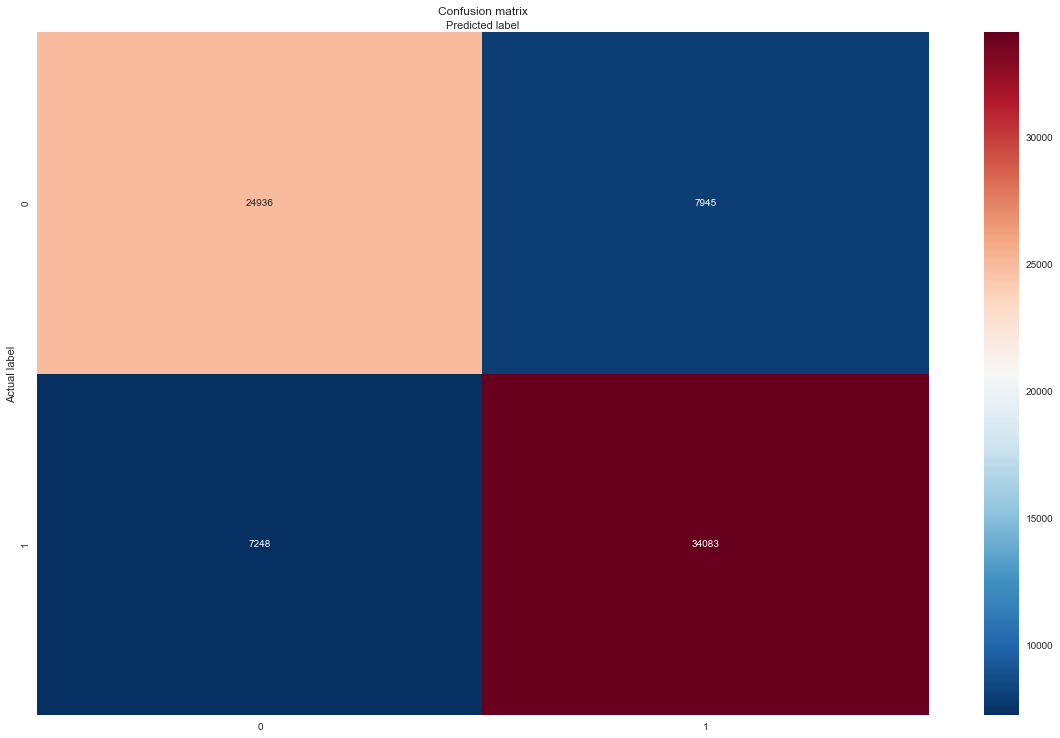

In [403]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="RdBu_r" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# The results are telling us that we have 24936+34083 correct predictions and 7248+7945 incorrect predictions.

In [395]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.77      0.76      0.77     32881
          1       0.81      0.82      0.82     41331

avg / total       0.79      0.80      0.80     74212



# ROC CURVE SCORE

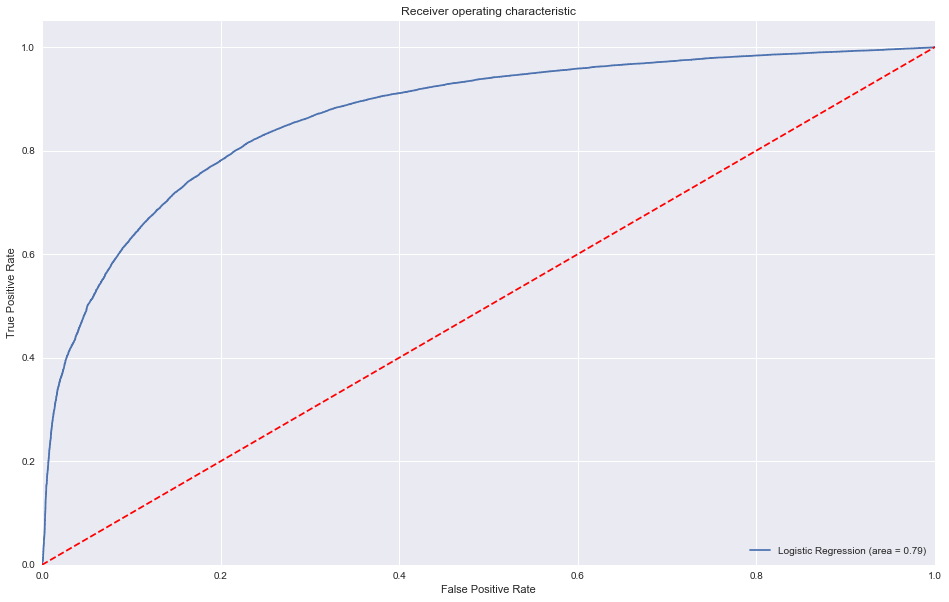

In [396]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc_score = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logReg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)'% logit_roc_auc_score)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()


# AUC value:

In [397]:
from sklearn.metrics import auc
auc = auc(fpr,tpr)
auc

0.8695948066948832

# ODDS RATIO FROM COEFFICIENTS:

In [398]:
from patsy import dmatrices
#formula = """DEATHS_BIN ~ GVWR+WEIGHT+DAY+DRIMPAIR+DR_SF4+HAZ_PLAC+IMPACT1+L_COMPL+L_RESTRI+L_TYPE+MAN_COLL+MDRDSTRD+MDRMANAV+
 #           P_CRASH2+ROLLOVER+VALIGN+VEH_SC1+VINTYPE+VTRAFCON+NUMOCCS+HIT_RUN"""
#formula = """DEATHS_BIN ~."""
all_columns = "+".join(new_df.columns)
all_columns = all_columns.strip().rstrip("+DEATHS_BIN")
my_formula = "DEATHS_BIN~" + all_columns

response, predictors = dmatrices(my_formula, new_df, return_type='dataframe')


In [400]:
logit_model=sm.Logit(response, predictors)
result=logit_model.fit(method='bfgs')
#print(result.params)

         Current function value: 0.365013
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 40


In [401]:
#result.params
coef = pd.DataFrame(result.params)
coef.columns = ['Coefficients']
odds_ratio=[]
probability =[]
for i in range(len(coef)):
    odds_ratio.append(np.exp(coef.iloc[i])[0])
coef.insert(1,column='Odds_ratio',value=odds_ratio)

for i in range(len(coef)):
    p = (coef.iloc[i])[1]
    probability.append(p*100/(1+p))
coef.insert(2,column='Probability',value=probability)

In [402]:
coef

,Coefficients,Odds_ratio,Probability
Intercept,0.182119,1.199757,54.540442
FIRE_EXP,1.588015,4.894026,83.033667
HAZ_INV,0.227126,1.254988,55.653876
TRAV_SP,0.000305,1.000305,50.007636
WEIGHT_1,0.735569,2.086669,67.602621
WEIGHT_2,0.060229,1.062080,51.505266
WEIGHT_3,-0.389014,0.677725,40.395478
WEIGHT_4,-0.129883,0.878198,46.757476
WEIGHT_5,-0.126789,0.880920,46.834526
WEIGHT_6,-0.303486,0.738241,42.470562


In [ ]:
# Results of feature selection for 10iterations, 20 agents, min 5 and max 25 features - 23 variables 
# Logistic Regression : 0.7952
# ['WEIGHT', 'CDL_STAT', 'DR_DRINK', 'LAST_YR', 'MDRDSTRD', 'MOD_YEAR', 'P_CRASH2', 'ROLLOVER', 'STATE', 'TOW_VEH', 'VEH_SC2', 'VINTYPE', 'VPAVETYP', 'VSURCOND', 'VTCONT_F', 'PREV_DWI', 'NUMOCCS', 'PREV_SPD', 'VNUM_LAN', 'VTRAFWAY', 'FIRE_EXP', 'HAZ_INV', 'TRAV_SP']

In [ ]:
# Results of feature selection for 10iterations, 20 agents, min 5 and max 25 features - 20 variables 
# Logistic Regression : 0.7949
# ['WEIGHT', 'DRIMPAIR', 'DR_SF3', 'HAZ_PLAC', 'LAST_YR', 'L_STATUS', 'MAKE', 'MDRDSTRD', 'MINUTE', 'MOD_YEAR', 'MONTH', 'P_CRASH2', 'SPEEDREL', 'TOW_VEH', 'VEH_SC1', 'VINTYPE', 'VTCONT_F', 'NUMOCCS', 'VE_FORMS', 'FIRE_EXP']

In [ ]:
# Results of feature selection for 10iterations, 20 agents, min 5 and max 50 features - 48 variables
# Logistic Regression : 0.8314
# ['DR_WGT', 'GVWR', 'WEIGHT', 'BUS_USE', 'CDL_STAT', 'DRIMPAIR', 'DR_DRINK', 'DR_HGT', 'DR_SF1', 'DR_SF3', 'DR_SF4', 'HARM_EV', 'HOUR', 'HAZ_PLAC', 'L_COMPL', 'L_RESTRI', 'L_TYPE', 'MAN_COLL', 'MDRDSTRD', 'MDRMANAV', 'MFACTOR', 'MINUTE', 'MONTH', 'MVIOLATN', 'MVISOBSC', 'OWNER', 'P_CRASH2', 'ROLLOVER', 'SPEC_USE', 'SPEEDREL', 'STATE', 'TOW_VEH', 'VALIGN', 'VEH_SC1', 'VINTYPE', 'VPAVETYP', 'VPROFILE', 'VTRAFCON', 'PREV_DWI', 'NUMOCCS', 'PREV_ACC', 'PREV_SUS', 'VE_FORMS', 'VNUM_LAN', 'VTRAFWAY', 'FIRE_EXP', 'HAZ_INV', 'TRAV_SP']

# Eventhough the first set gave lesser variable(16), the latter one gives meaningful set of variables.

In [309]:
# %load SDSFS.py  -  MAGIC FUNCTION
##importing necessary libraries
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from pprint import pprint
import statsmodels.api as sm

#Creating instances of estimators
logReg=LogisticRegression()
decClf=DecisionTreeClassifier(max_depth=5, min_samples_split=4)
#svc=SVC(C=0.5,gamma=0.5)

estimators=[logReg] 

'''
Below function returns an agent, which is hypothesis, and its corresponding binary array.
1 indicates inclusion of corresponding feature and 0 indicates exclusion of the feature.
lowerLim indicates minimum number of features, whereas; upperLim indicated max no of features to beincluded in an agent.
'''
def agent(arryX,lowerLim,upperLim):
        if lowerLim<0 or upperLim>arryX.shape[1]:
            print('recall function with appropriate limits')
        else:
            randomNoFeatures=np.random.randint(lowerLim,upperLim,size=1)[0] #generating a random number
            zeroArry=np.zeros(arryX.shape[1]-randomNoFeatures, dtype='int') #zero array 
            oneArry=np.ones(randomNoFeatures, dtype='int')   #one array
            fArry=np.concatenate((zeroArry,oneArry), axis=0) #concatinating zero and one array
            np.random.shuffle(fArry) #shuffling fArray
            fIndex=np.where(fArry==1)[0]
            agentArry=arryX[:,fIndex] #generating feature subset from origanal dataset
            return fArry,agentArry

'''
Below function generates required number of agents that are to be deployed on search space. 
All the agents and corresponding binary feature array are stored and returned as a list.
'''
def agentsInitiation(arryX,numAgents,lowerLim,upperLim):
        agents=[]
        agentFIndex=[]
        agentStatus=['active']*numAgents
        for i in range(0,numAgents):
            fArry,agentArry=agent(arryX,lowerLim,upperLim) #generating a single agent
            agentFIndex.append(fArry) #appending its binary feature array to agentFIndex
            agents.append(agentArry) #appending the agent to the agents list
        return agents,agentFIndex,agentStatus

'''
'Score' function fits each model to the agent's training data and then evaluates the score on test agent. 
The output is the average score of three estimators. Original paper used only one classifier to calculate score.
Therefore, the resultant subset was very biased towards the signle estimator. 
To avoind this, we are using ensemble of classifiers.
'''
def score(estimators,arryX,arrY):
        X_train,X_test,y_train,y_test=train_test_split(arryX,arrY,random_state=0)
        scores=[]
        
        for i in range(len(estimators)):
            estimators[i].fit(X_train,y_train) #fitting the ith estimator to the training data of an agent
            
            scores.append(estimators[i].score(X_test,y_test)) #evaluating the score on the test data
            
        return sum(scores)/len(scores)
    
#below function calculates score for each agents and appends the score to the agentScores list
def agentClfscores(estimators,agents,arrY):
    agentScores=[]
    for agent in agents:
        
        agentscore=score(estimators,agent,arrY)
        #agentscore=scorePoisson(agent,arrY)
        agentScores.append(agentScores)
    return agentScores #returns a list that caputres agents' scores

'''
Below function carries out test and diffusion phase among the agents initialized above. 
The function returns agents and their corresponding scores, binary feature arrays, and staus after numIterations.
'''

def SDSFS(arryX,arrY,estimators,numIterations,numAgents,lowerLim,upperLim):
    agents,agentFIndex,agentStatus=agentsInitiation(arryX,numAgents,lowerLim,upperLim)
    #print("testing phase")
    agentScores=agentClfscores(estimators,agents,arrY)
    
    niters=0
    while niters<numIterations:
        #testing phase
        for i in range(len(agents)):
            rndmId=np.random.randint(len(agents),size=1)[0]
            if agentScores[i]>agentScores[rndmId]:
                agentStatus[i]='active' 
                
            else:
                agentStatus[i]='inactive'
                
        #Diffusion phase
        #print("Diffusion phase")
        for i in range(len(agents)):
                if agentStatus[i]=='inactive':
                    rndmId2=np.random.randint(len(agents),size=1)[0]
                    if agentStatus[rndmId2]=='active':
                        oneIds=np.where(agentFIndex[rndmId2]==1)[0]
                        zeroIds=np.where(agentFIndex[rndmId2]==0)[0]
                        rndmId3=np.random.randint(len(oneIds), size=1)
                        rndmId4=np.random.randint(len(zeroIds), size=1)
                        oneZeroId=oneIds[rndmId3]
                        zeroOneId=zeroIds[rndmId4]
                        agentFIndex[i]=agentFIndex[rndmId2].copy()
                        agentFIndex[i][oneZeroId]=0
                        agentFIndex[i][zeroOneId]=1
                        fIndex2=np.where(agentFIndex[i]==1)[0]
                        agents[i]=X[:,fIndex2]
                        agentScores[i]=score(estimators,agents[i],arrY)
                    else:
                        agentFIndex[i],agents[i]=agent(arryX,lowerLim,upperLim)
                        agentScores[i]=score(estimators,agents[i],arrY)
                else:
                    rndmId5=np.random.randint(len(agents),size=1)[0]
                    if agentStatus[rndmId5]=='active' and (agentFIndex[i]==agentFIndex[rndmId5]).all():
                        agentStatus[i]='inactive'
                        agentFIndex[i],agents[i]=agent(arryX,lowerLim,upperLim)
                        agentScores[i]=score(estimators,agents[i],arrY)
        niters+=1
        #print("Iteration = ",niters)
    return agents,agentFIndex,agentStatus,agentScores